# Data

In [48]:
import numpy as np 
import pandas as pd

# Convert the lists to numpy arrays
N = 100
timestep = 30
timestamps = np.linspace(0, N*timestep//3, N) + np.random.randint(-5, 5, size=N)
cloud_cover = np.random.randint(0, 10, size=N)
spatial_res = np.random.choice([10, 15, 30], size=N)
nodata = np.random.randint(0, 25, size=N)

# Calculate the time difference between images in days
df = pd.DataFrame({'timestamps': timestamps, 'cloud_cover': cloud_cover, 'spatial_res': spatial_res, 'nodata': nodata})
df

,timestamps,cloud_cover,spatial_res,nodata
0,-1.00000,8,10,14
1,5.10101,3,15,24
2,21.20202,6,15,4
3,30.30303,0,15,22
4,36.40404,7,30,1
...,...,...,...,...
95,954.59596,9,15,17
96,965.69697,2,15,6
97,978.79798,3,10,13
98,987.89899,4,30,0


# Graph

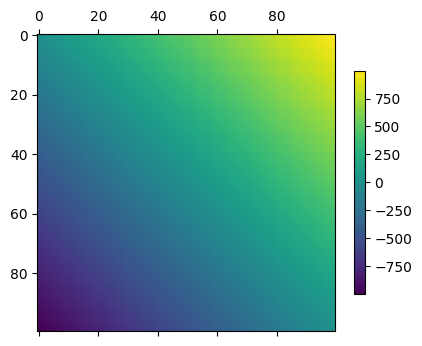

In [49]:
#build timestamp difference matrix
import matplotlib.pyplot as plt

x = np.ones(N)
deltaT = np.outer(x, timestamps) - np.outer(timestamps, x)
plt.matshow(deltaT)
plt.colorbar(shrink=0.6)

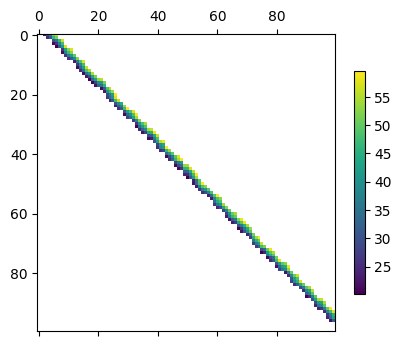

In [50]:
#Filtering matrix by lb and ub

lb = 20
ub = 60
deltaT_cond = deltaT.copy()
deltaT_cond[ (abs(deltaT) > ub) | (abs(deltaT) < lb) ] = np.nan
deltaT_cond[ deltaT < 0 ] = np.nan
plt.matshow(deltaT_cond)
plt.colorbar(shrink=0.6)

In [51]:
import networkx as nx
import datetime

# Assuming you have a list of dates called 'date_list'
# and you have already created the NxN matrix of time differences called 'time_diff_matrix'

# Create an empty graph
graph = nx.DiGraph()

# Add nodes to the graph
for i in range(len(timestamps)):
    row = df.iloc[i]
    attributes = {
        'cloud_cover': row['cloud_cover'],
        'spatial_res': row['spatial_res'],
        'nodata' : row['nodata'], 
        'date' : row['timestamps']
    }
    graph.add_node(i, **attributes)

# Add edges to the graph based on the time differences
for i in range(len(timestamps)):
    for j in range(i+1, len(timestamps)):
        time_diff = deltaT_cond[i][j]
        
        if 20 < time_diff < 50:
            if i < j:
                graph.add_edge(i, j, weight = time_diff)
            else:
                graph.add_edge(j, i, weight = time_diff)

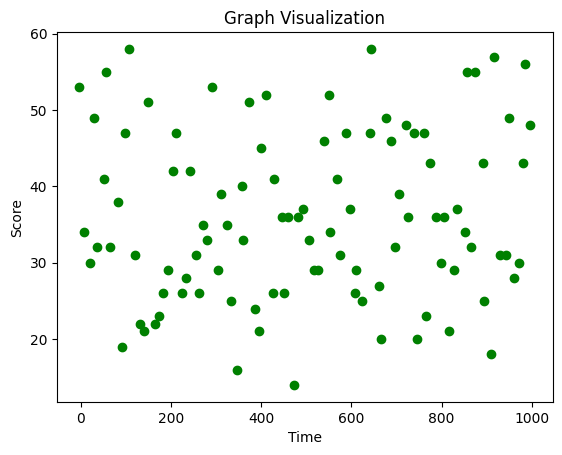

In [20]:
import networkx as nx
import matplotlib.pyplot as plt

# Assuming you have already created the graph called 'graph' with node attributes

# Extract node attributes for plotting
x = [graph.nodes[n]['date'] for n in graph.nodes()]
attribute1_list = [graph.nodes[n]['cloud_cover'] for n in graph.nodes()]
attribute2_list = [graph.nodes[n]['spatial_res'] for n in graph.nodes()]
attribute3_list = [graph.nodes[n]['nodata'] for n in graph.nodes()]
a = 1
b = 1
c = 1 
scores = [a * x + b * y + c * z for x, y, z in zip(attribute1_list, attribute2_list, attribute3_list)]

# Create a scatter plot of nodes
plt.scatter(x, scores, color='green')
plt.title('Graph Visualization')
plt.xlabel('Time')
plt.ylabel('Score')

# # Add arrows to the plot for directed edges
# for edge in graph.edges():
#     plt.arrow(x[edge[0]], scores[edge[0]], x[edge[1]] - x[edge[0]], scores[edge[1]] - scores[edge[0]], color='blue', alpha=0.5, width=0.1, head_width=1, length_includes_head=True, lw=0.5)

plt.show()

# Optimization 

Find the path that : 
1. Minimize the score 
2. use approximately edges that have the same length (weight)

In [57]:
import statistics

def get_scores(graph, nodes, cc_ub, sr_ub, nd_ub):
    #score 
    attribute1_list = [graph.nodes[n]['cloud_cover'] for n in nodes]
    attribute2_list = [graph.nodes[n]['spatial_res'] for n in nodes]
    attribute3_list = [graph.nodes[n]['nodata'] for n in nodes]
    return [1/cc_ub * x + 1/sr_ub * y + 1/nd_ub * z for x, y, z in zip(attribute1_list, attribute2_list, attribute3_list)], attribute1_list, attribute2_list, attribute3_list

def get_metrics(graph, shortest_path, cc_ub=10, sr_ub=30, nd_ub=25):
    """_summary_
    
    Args:
        graph (_type_): _description_
        shortest_path (_type_): _description_
        a (int, optional): _description_. Defaults to 1.
        b (int, optional): _description_. Defaults to 1.
        c (int, optional): _description_. Defaults to 1.

    Returns:
        _type_: _description_
    """

    #score 
    scores, attribute1_list, attribute2_list, attribute3_list = get_scores(graph, shortest_path, cc_ub, sr_ub, nd_ub)
    avg_score = statistics.mean(scores)
    avg_cloud_cover = statistics.mean(attribute1_list)
    avg_spatial_res = statistics.mean(attribute2_list)
    avg_nodata = statistics.mean(attribute3_list)

    #weight
    weights = [graph.edges[n]['weight'] for n in zip(shortest_path, shortest_path[1:])]
    avg_weight = statistics.mean(weights)
    std_dev_weight = statistics.stdev(weights)

    return avg_score, avg_cloud_cover, avg_spatial_res, avg_nodata, avg_weight, std_dev_weight


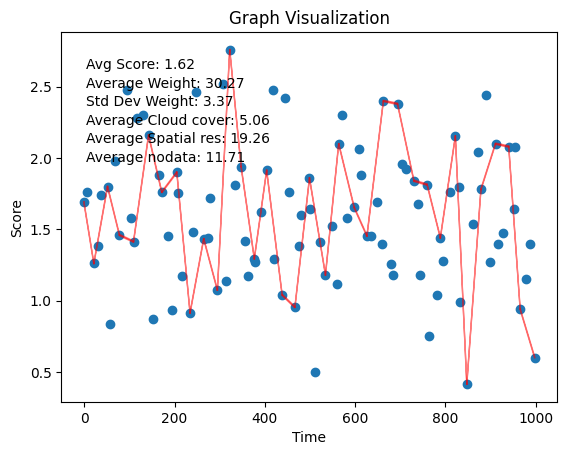

In [56]:
#V1 without buffer
import statistics

# Assuming you have already created the directed graph called 'graph' with node attributes

# Define the weight function
def weight_function(u, v, graph, target_weight):
    # Calculate the weight based on the difference between the actual weight and the target weight
    actual_weight = graph[u][v]['weight']
    weight_diff = abs(actual_weight - target_weight)
    return weight_diff

# Set the target weight
target_weight = 30  # Adjust this value to your desired target weight

# Find the shortest path using Dijkstra's algorithm with the custom weight function
shortest_path = nx.shortest_path(graph, source=0, target=len(graph) - 1, weight=lambda u, v, d: weight_function(u, v, graph, target_weight))

# Create a scatter plot of nodes
scores, _, _, _ = get_scores(graph, graph.nodes(), cc_ub=10, sr_ub=30, nd_ub=25)
x = [graph.nodes[n]['date'] for n in graph.nodes()]
plt.scatter(x, scores)
plt.title('Graph Visualization')
plt.xlabel('Time')
plt.ylabel('Score')

# Add arrows to the plot for the shortest path
for i in range(len(shortest_path) - 1):
    u = shortest_path[i]
    v = shortest_path[i+1]
    plt.arrow(x[u], scores[u], x[v] - x[u], scores[v] - scores[u], color='red', alpha=0.5, width=0.01, head_width=0.01, length_includes_head=True, linestyle='solid')

#compute metrics
avg_score, average_attribute1, average_attribute2, average_attribute3, average_weight, std_dev_weight = get_metrics(graph, shortest_path)

# Add arrows to the plot for directed edges
plt.text(0.05, 0.75, f'Average Cloud cover: {average_attribute1:.2f}', transform=plt.gca().transAxes)
plt.text(0.05, 0.7, f'Average Spatial res: {average_attribute2:.2f}', transform=plt.gca().transAxes)
plt.text(0.05, 0.65, f'Average nodata: {average_attribute3:.2f}', transform=plt.gca().transAxes)

plt.text(0.05, 0.9, f'Avg Score: {avg_score:.2f}', transform=plt.gca().transAxes)

plt.text(0.05, 0.85, f'Average Weight: {average_weight:.2f}', transform=plt.gca().transAxes)
plt.text(0.05, 0.8, f'Std Dev Weight: {std_dev_weight:.2f}', transform=plt.gca().transAxes)

plt.show()

Avg Score: 1.55, Avg Cloud cover: 5.21, Avg Spatial res: 18.68, Avg nodata: 10.24, Avg Weight: 29.97, Std Dev Weight: 3.49


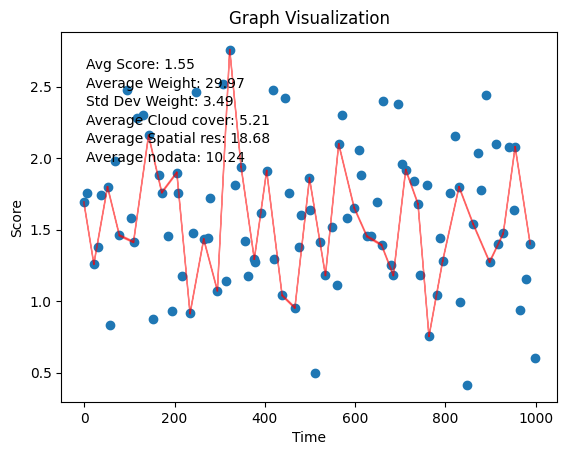

In [66]:
#with buffer
import math

# Find the path that minimizes the sum of scores while considering weights with approximately the same weight
start_node = 0
end_node = len(timestamps) - 1
shortest_path = None
min_score = (math.inf, math.inf)
buffer = 15 #days

# Iterate over possible start and end nodes within the buffer time period
for i in range(0, 10):
    start_date = graph.nodes[start_node]['date']
    possible_start = graph.nodes[i]
    possible_start_date = possible_start['date']
    time_diff_start = abs(possible_start_date - start_date)

    if time_diff_start <= buffer:
        for j in range(len(timestamps) - 10, len(timestamps)):
            end_date = graph.nodes[end_node]['date']
            possible_end = graph.nodes[j]
            possible_end_date = possible_end['date']
            time_diff_end = abs(possible_end_date - end_date)

            if time_diff_end <= buffer:
                path = nx.shortest_path(graph, i, j, weight=lambda u, v, d: weight_function(u, v, graph, target_weight))

                if path is not None:
                    #compute metrics
                    avg_score, avg_cloud_cover, avg_spatial_res, avg_nodata, avg_weight, std_dev_weight = get_metrics(graph, path)
                    tmp_score = (avg_score, abs(target_weight - avg_weight))
                    if tmp_score < min_score:
                        min_score = tmp_score
                        shortest_path = path
                        print(f'Avg Score: {avg_score:.2f}, Avg Cloud cover: {avg_cloud_cover:.2f}, Avg Spatial res: {avg_spatial_res:.2f}, Avg nodata: {avg_nodata:.2f}, Avg Weight: {avg_weight:.2f}, Std Dev Weight: {std_dev_weight:.2f}')

# Create a scatter plot of nodes
scores, _, _, _ = get_scores(graph, graph.nodes(), cc_ub=10, sr_ub=30, nd_ub=25)
x = [graph.nodes[n]['date'] for n in graph.nodes()]
plt.scatter(x, scores)
plt.title('Graph Visualization')
plt.xlabel('Time')
plt.ylabel('Score')

# Add arrows to the plot for the shortest path
for i in range(len(shortest_path) - 1):
    u = shortest_path[i]
    v = shortest_path[i+1]
    plt.arrow(x[u], scores[u], x[v] - x[u], scores[v] - scores[u], color='red', alpha=0.5, width=0.01, head_width=0.01, length_includes_head=True, linestyle='solid')

#compute metrics
avg_score, average_attribute1, average_attribute2, average_attribute3, average_weight, std_dev_weight = get_metrics(graph, shortest_path)

# Add arrows to the plot for directed edges
plt.text(0.05, 0.75, f'Average Cloud cover: {average_attribute1:.2f}', transform=plt.gca().transAxes)
plt.text(0.05, 0.7, f'Average Spatial res: {average_attribute2:.2f}', transform=plt.gca().transAxes)
plt.text(0.05, 0.65, f'Average nodata: {average_attribute3:.2f}', transform=plt.gca().transAxes)

plt.text(0.05, 0.9, f'Avg Score: {avg_score:.2f}', transform=plt.gca().transAxes)

plt.text(0.05, 0.85, f'Average Weight: {average_weight:.2f}', transform=plt.gca().transAxes)
plt.text(0.05, 0.8, f'Std Dev Weight: {std_dev_weight:.2f}', transform=plt.gca().transAxes)

plt.show()

In [85]:
#TO DO : modify algorithm with buffer to select the best path in accordance with : avg weight, avg attributes...
#TO DO : modify the weight function to take into account the score 